# Chapter 11: Support vector machine (SVM)

### 11.1. Preparation of data
> ###### 11.1.1. Features engineering
> ###### 11.1.2. Standardization

### 11.2. Support vector classifier (SVC)
> ###### 11.2.1. Intuition about how works an SVC
> ###### 11.2.2. Implementation of the model
> ###### 11.2.3. Predictions and backtest

### 11.3. Support vector regressor (SVR)
> ###### 11.3.1. Intuition about how works an SVR
> ###### 11.3.2. Implementation of the model
> ###### 11.3.3. Predictions and backtest

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
plt.style.use('seaborn')
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
from Backtest import *

### 11.1.1. Features enginneering

In [2]:
# Import EURUSD data
df = yf.download("GOOG", end="2021-01-01")[["Adj Close"]].pct_change(1)
df.columns = ["returns"]

# Features engeeniring
df["returns t-1"] = df[["returns"]].shift(1)

# Mean of returns
df["mean returns 15"] = df[["returns"]].rolling(15).mean().shift(1)
df["mean returns 60"] = df[["returns"]].rolling(60).mean().shift(1)

# Volatility of returns
df["volatility returns 15"] = df[["returns"]].rolling(15).std().shift(1)
df["volatility returns 60"] = df[["returns"]].rolling(60).std().shift(1)

# Drop missing values
df = df.dropna()

[*********************100%***********************]  1 of 1 completed


In [3]:
# Percentage train set
split = int(0.80*len(df))

# Train set creation
X_train = df[["returns t-1", "mean returns 15", "mean returns 60",
              "volatility returns 15",
              "volatility returns 60"]].iloc[:split]

y_train_reg = df[["returns"]].iloc[:split]

y_train_cla = np.round(df[["returns"]].iloc[:split]+0.5)


# Test set creation
X_test = df[["returns t-1", "mean returns 15", "mean returns 60",
              "volatility returns 15",
              "volatility returns 60"]].iloc[split:]

y_test_reg = df[["returns"]].iloc[split:]
y_test_cla = np.round(df[["returns"]].iloc[split:]+0.5)

### 11.1.2. Standardization

In [4]:
# Import the class
from sklearn.preprocessing import StandardScaler

# Initialize the class
sc = StandardScaler()

# Standardize the data
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

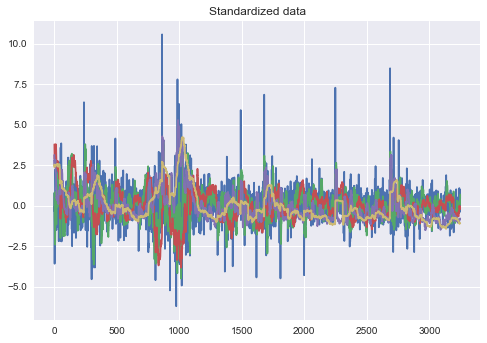

In [5]:
plt.plot(X_train_scaled)
plt.title("Standardized data")
plt.show()

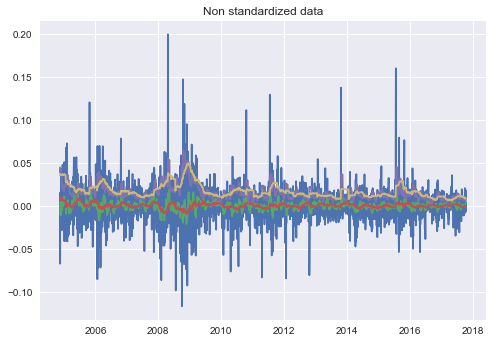

In [6]:
plt.plot(X_train)
plt.title("Non standardized data")
plt.show()

### 11.2.2. Implement an SVC

In [7]:
# Import the class
from sklearn.svm import SVC

# Initialize the class
svc = SVC()

# Fit the model
svc.fit(X_train_scaled, y_train_cla)

SVC()

### 11.2.3. Predictions ans backtest

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 0.248 	 Alpha: -21.69 %	     Sharpe: -0.602 	 Sortino: -0.684
  -----------------------------------------------------------------------------
    VaR: 88.25 %	 cVaR: 98.29 % 	     VaR/cVaR: 1.114 	 drawdown: 67.1 %
  -----------------------------------------------------------------------------


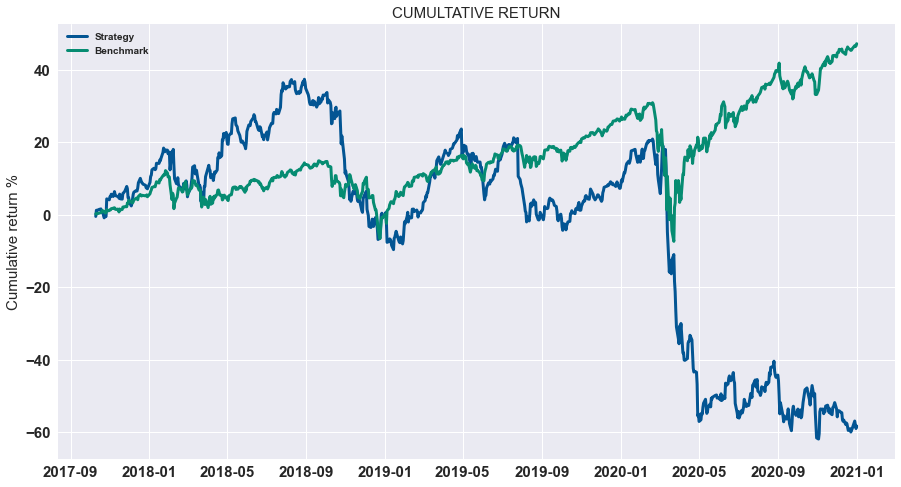

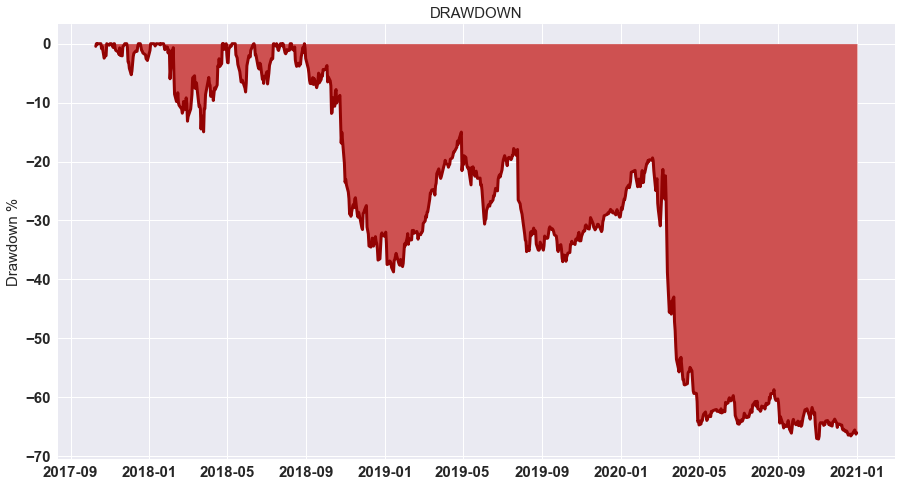

In [8]:
# Create predictions for the whole dataset
df["prediction"] = svc.predict(np.concatenate((X_train_scaled,X_test_scaled),
                                    axis=0))
df["prediction"] = np.where(df["prediction"]==0, -1, 1)

# Compute the strategy
df["strategy"] = df["prediction"] * df["returns"]

# Backtest
backtest_dynamic_portfolio(df["strategy"].iloc[split:])

### 11.3.2. Implement an SVR

In [9]:
# Import the class
from sklearn.svm import SVR

# Initialize the class
lr = SVR()

# Fit the model
lr.fit(X_train_scaled, y_train_reg)

SVR()

### 11.3.3. Predictions and backtest

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 0.787 	 Alpha: 2.15 %	     Sharpe: 0.455 	 Sortino: 0.584
  -----------------------------------------------------------------------------
    VaR: 56.31 %	 cVaR: 65.91 % 	     VaR/cVaR: 1.17 	 drawdown: 30.32 %
  -----------------------------------------------------------------------------


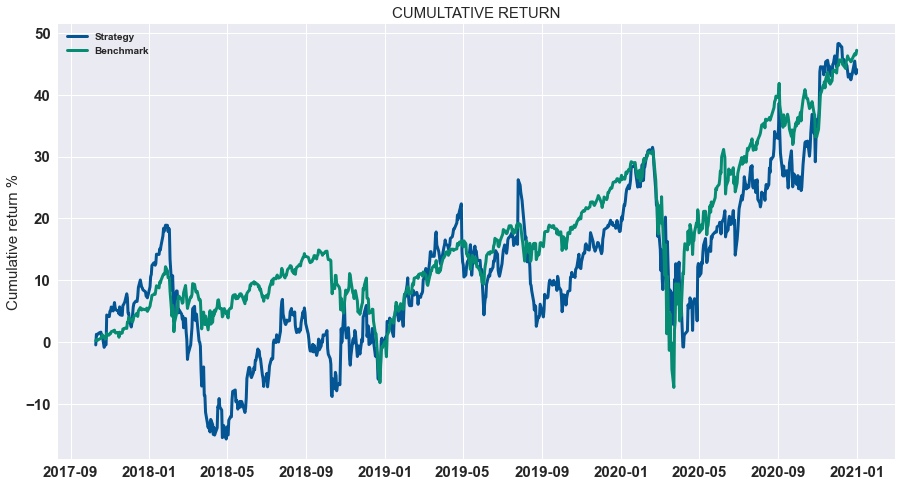

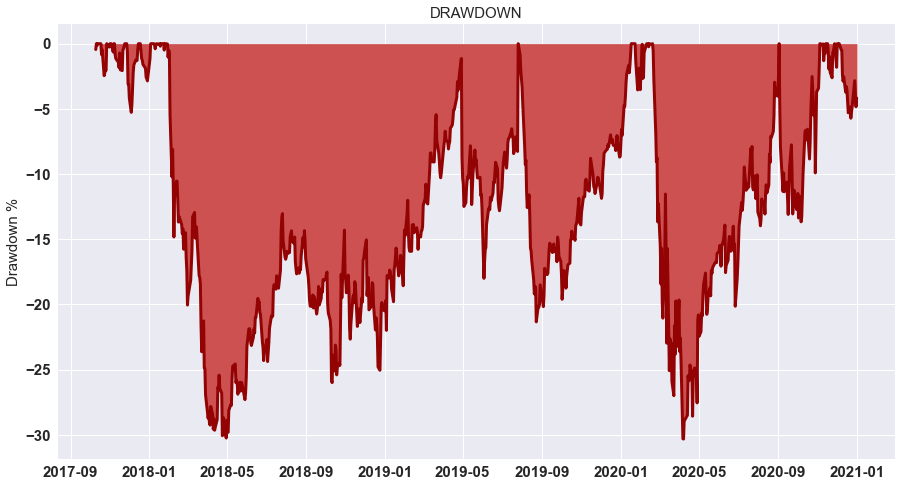

In [10]:
# Create predictions for the whole dataset
df["prediction"] = lr.predict(np.concatenate((X_train_scaled,X_test_scaled),
                                    axis=0))
# Compute the strategy
df["strategy"] = np.sign(df["prediction"]) * df["returns"]

# Backtest
backtest_dynamic_portfolio(df["strategy"].iloc[split:])